## Imports

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas
import seaborn as sns
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spark = SparkSession.builder.master("local[*]").appName('House_analysis').getOrCreate()#
spark

23/05/31 14:17:13 WARN Utils: Your hostname, DESKTOP-21T818B resolves to a loopback address: 127.0.1.1; using 172.18.5.97 instead (on interface eth0)
23/05/31 14:17:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/31 14:17:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/31 14:17:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/31 14:17:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Data load

In [3]:
df = spark.read.csv('./data/house_data', header=True, inferSchema=True)
df.toPandas()

23/05/31 14:17:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DwellingType                    ZoneType   
0                2-STORY 1946 & NEWER     Residential Low Density  \
1     1-STORY 1946 & NEWER ALL STYLES     Residential Low Density   
2                2-STORY 1946 & NEWER     Residential Low Density   
3                2-STORY 1945 & OLDER     Residential Low Density   
4                2-STORY 1946 & NEWER     Residential Low Density   
...                               ...                         ...   
2914       2-STORY PUD - 1946 & NEWER  Residential Medium Density   
2915       2-STORY PUD - 1946 & NEWER  Residential Medium Density   
2916  1-STORY 1946 & NEWER ALL STYLES     Residential Low Density   
2917                      SPLIT FOYER     Residential Low Density   
2918             2-STORY 1946 & NEWER     Residential Low Density   

      LotFrontage  LotArea Street             Alley            LotShape   
0              65     8450  Paved  Not Alley Access             Regular  \
1              80     9600  Paved  Not Alley Access             Regular   
2              68    11250  Paved  Not Alley Access  Slightly irregular   
3              60     9550  Paved  Not Alley Access  Slightly irregular   
4              84    14260  Paved  Not Alley Access  Slightly irregular   
...           ...      ...    ...               ...                 ...   
2914           21     1936  Paved  Not Alley Access             Regular   
2915           21     1894  Paved  Not Alley Access             Regular   
2916          160    20000  Paved  Not Alley Access             Regular   
2917           62    10441  Paved  Not Alley Access             Regular   
2918           74     9627  Paved  Not Alley Access             Regular   

             Flatness             Utilities LotConfig  ... ImpactView   
0     Near Flat/Level  All public Utilities    Inside  ...   0.038462  \
1     Near Flat/Level  All public Utilities       FR2  ...   0.066667   
2     Near Flat/Level  All public Utilities    Inside  ...   0.030222   
3     Near Flat/Level  All public Utilities    Corner  ...   0.031414   
4     Near Flat/Level  All public Utilities       FR2  ...   0.029453   
...               ...                   ...       ...  ...        ...   
2914  Near Flat/Level  All public Utilities    Inside  ...   0.075930   
2915  Near Flat/Level  All public Utilities    Inside  ...   0.055438   
2916  Near Flat/Level  All public Utilities    Inside  ...   0.056000   
2917  Near Flat/Level  All public Utilities    Inside  ...   0.029691   
2918  Near Flat/Level  All public Utilities    Inside  ...   0.038434   

     RoomsMeanSize RegularRooms GarageAreaPerCars GarageAreaQuality   
0       213.750000            4        274.000000              1644  \
1       210.333333            2        230.000000              1380   
2       297.666667            2        304.000000              1824   
3       245.285714            3        214.000000              1926   
4       244.222222            4        278.666667              2508   
...            ...          ...               ...               ...   
2914    218.400000            1          0.000000                 0   
2915    182.000000            2        286.000000               858   
2916    174.857143            2        288.000000              1728   
2917    161.666667            2          0.000000                 0   
2918    222.222222            5        216.666667              1950   

     BasementAreaQuality  LivingAreaQuality  LivingAreaCondition   
0                   3424              11970                 8550  \
1                   5048               7572                10096   
2                   3680              12502                 8930   
3                   2268              12019                 8585   
4                   4580              17584                10990   
...                  ...                ...                  ...   
2914                1638               4368                 7644   
2915                1

## Analising the data

In [4]:
numeric_cols = [col for col, dtype in df.dtypes if dtype != 'string']
string_cols = [col for col, dtype in df.dtypes if dtype == 'string']

In [5]:
len(numeric_cols)

71

Checking behavior of SalePrice when changing individual feature value

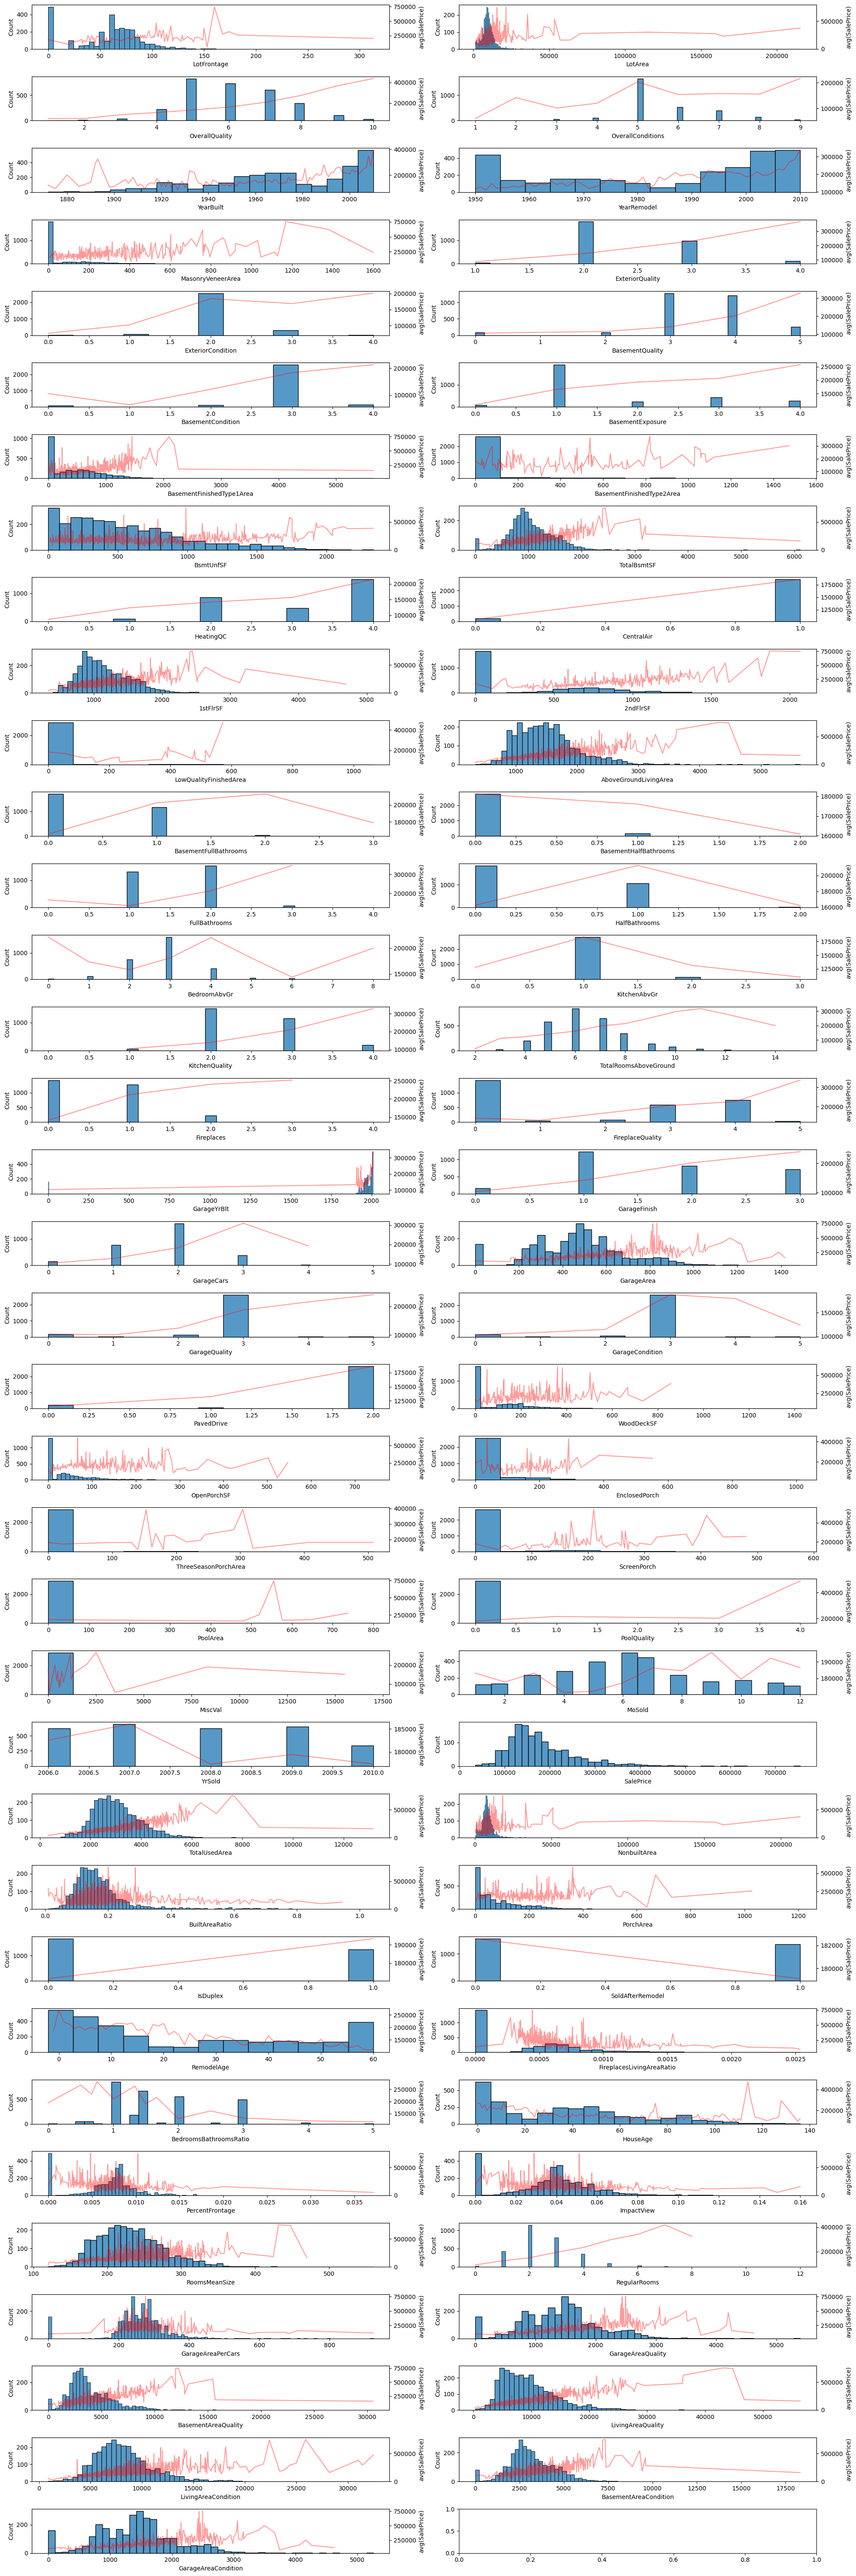

In [21]:
fig, axs = plt.subplots(nrows=36, ncols=2, figsize=(20, 60))
axs = axs.reshape(-1)
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df.toPandas(), x=col, ax=axs[i])
    if col != "SalePrice":
        axs2 = axs[i].twinx()
        sns.lineplot(data=df.select(col, 'SalePrice').groupby(col).mean().toPandas(), x=col, y='avg(SalePrice)', color='r', alpha=0.4, ax=axs2)
    plt.tight_layout()

Another visualization with the same objective

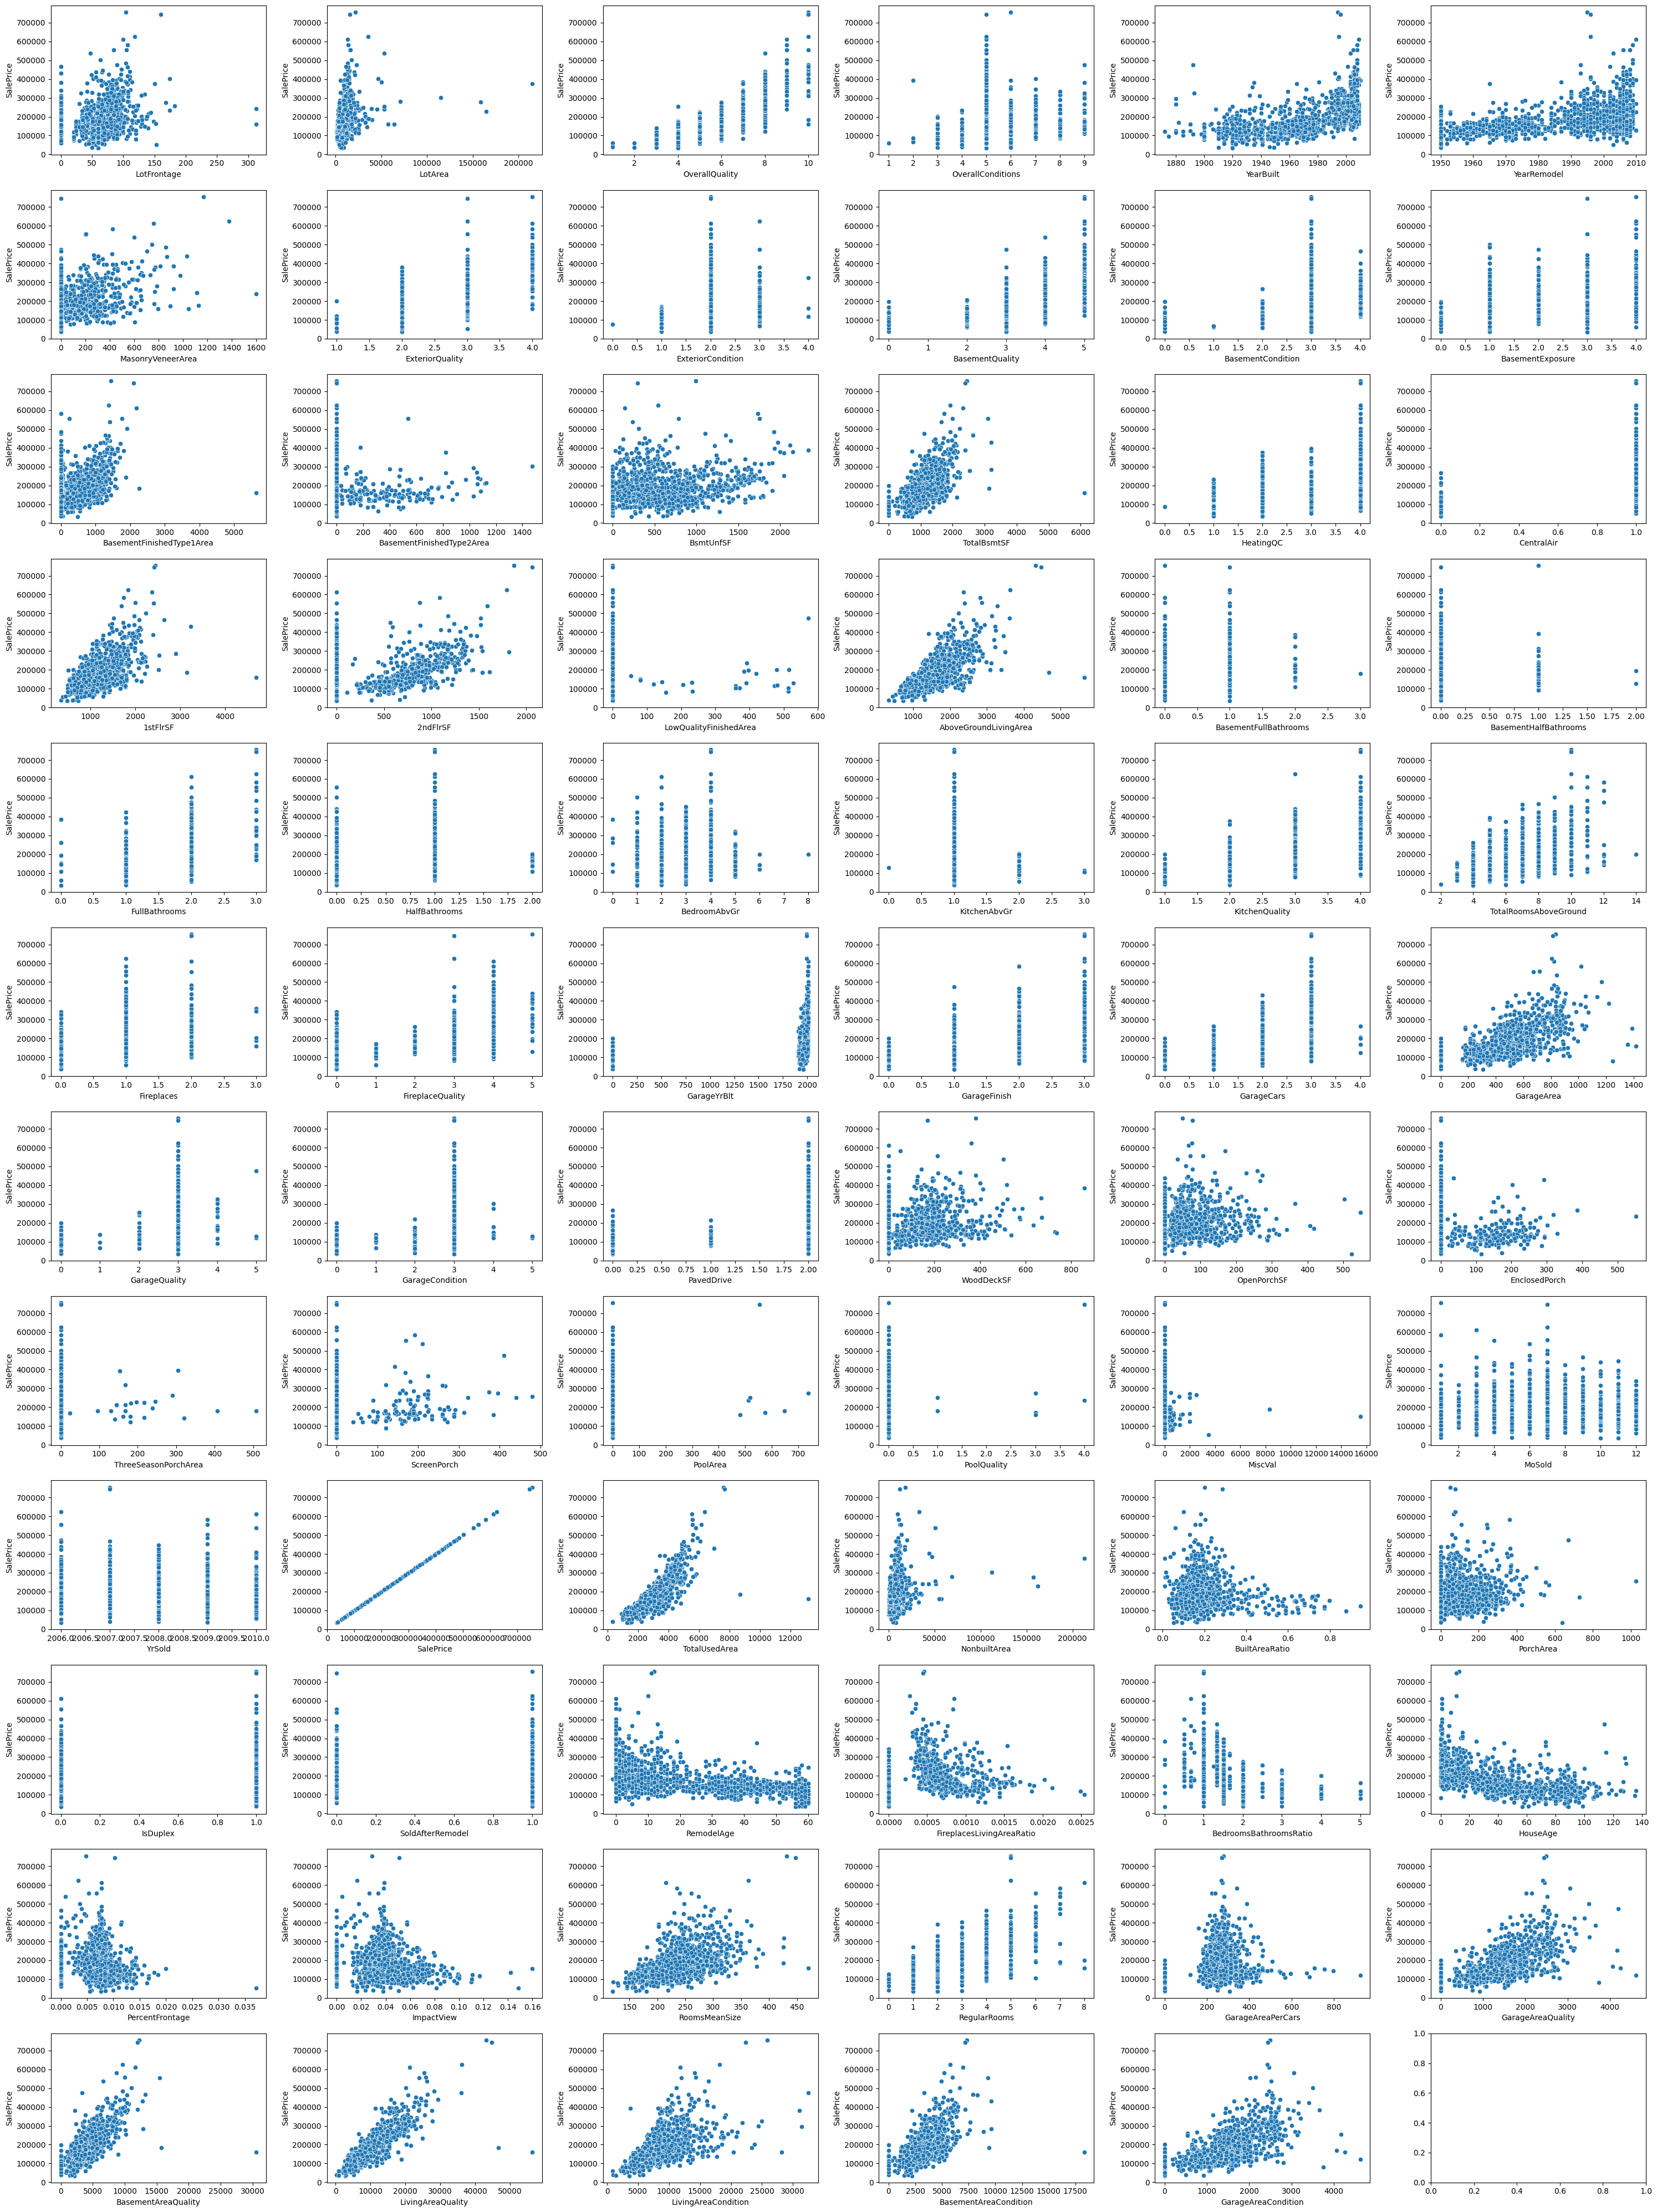

In [30]:
fig, axes = plt.subplots(nrows=12, ncols=6, figsize=(30, 40))
axes = np.ravel(axes)
for i, col in enumerate(numeric_cols):
    sns.scatterplot(data=df.toPandas(), x=col, y='SalePrice', ax=axes[i])
plt.tight_layout()

In [31]:
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df[numeric_cols].dropna())

matrix = Correlation.corr(df_vector, "features", method='spearman')
matrix = matrix.collect()[0][0].toArray()

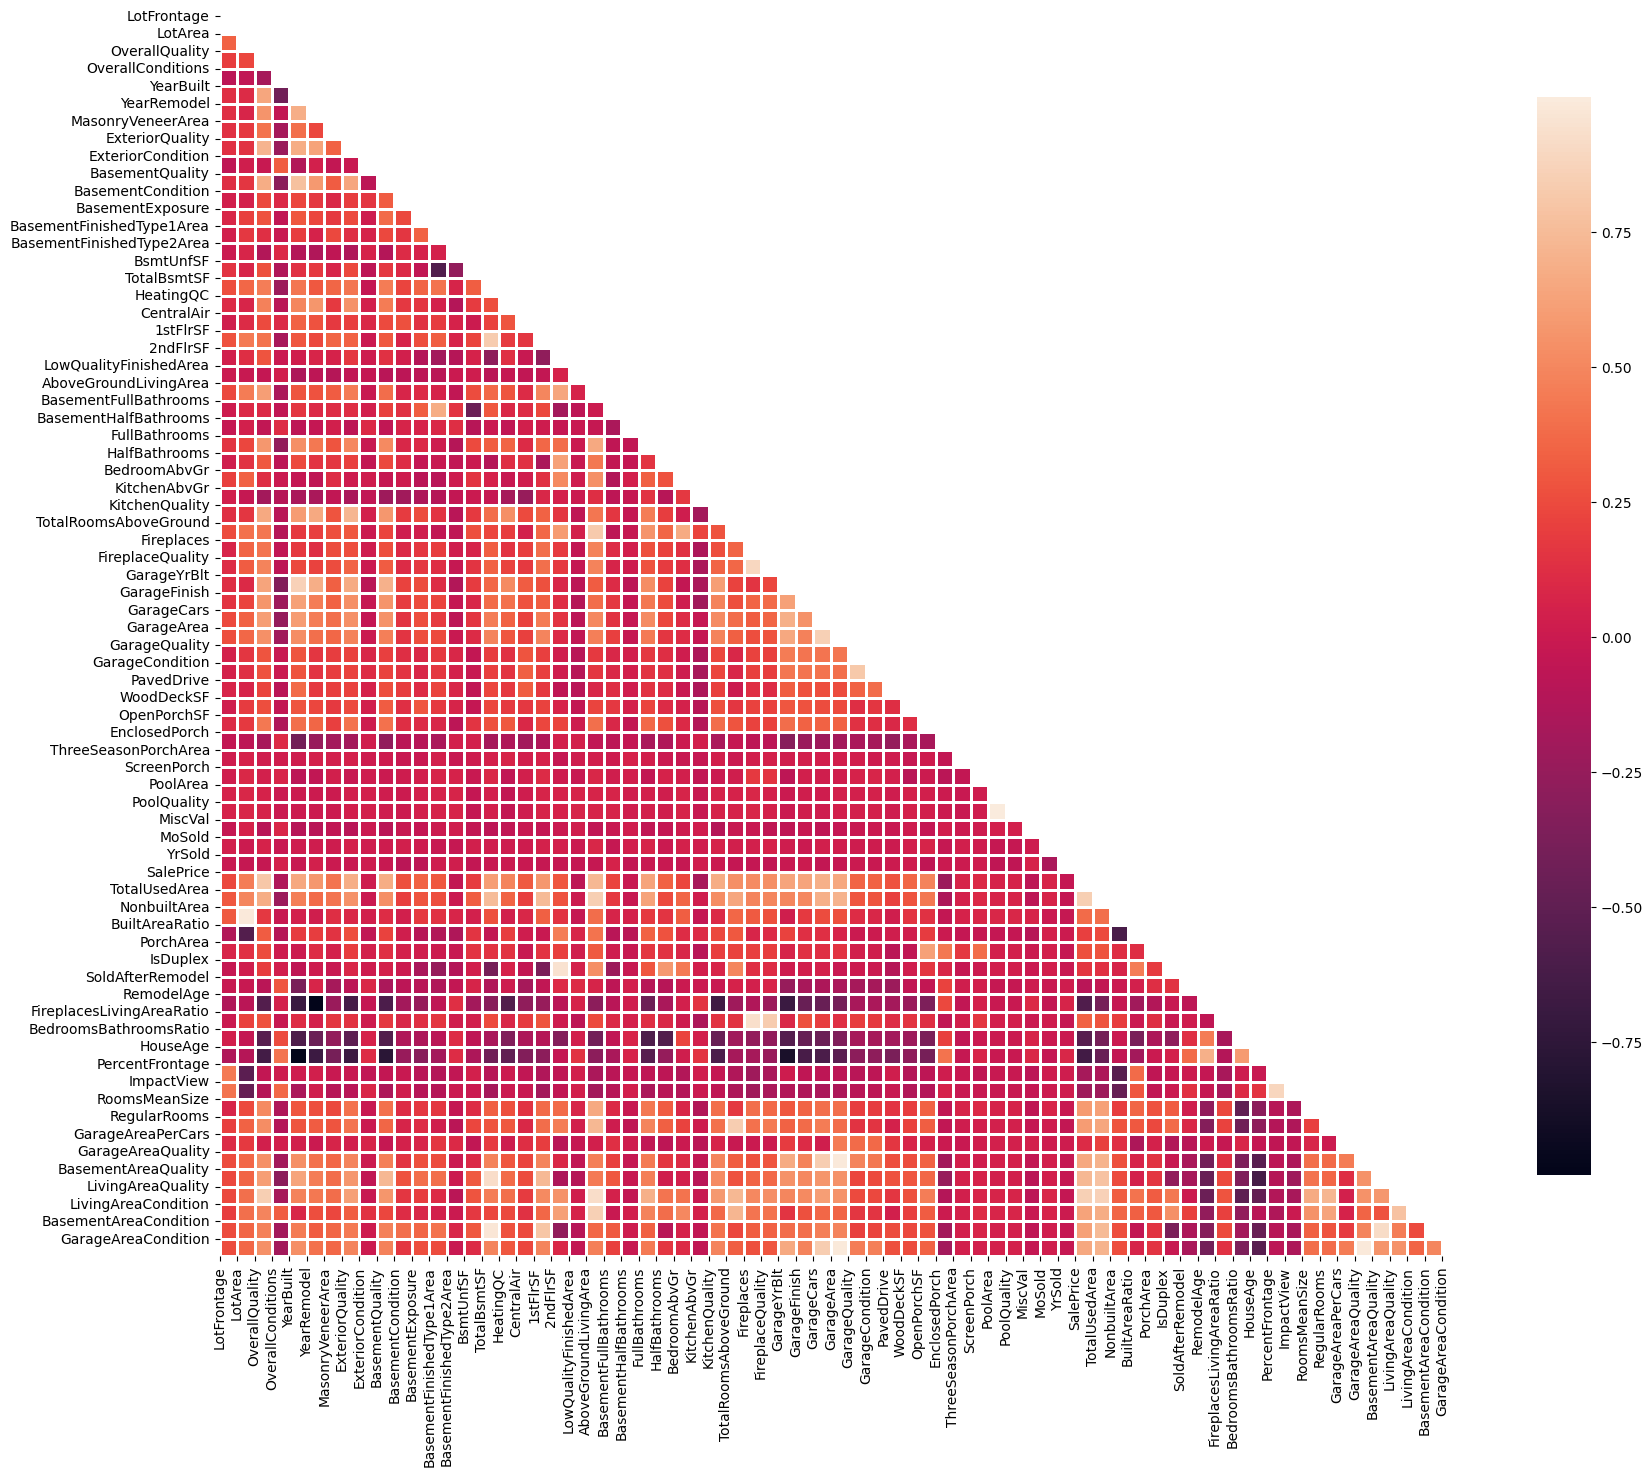

In [32]:
plt.figure(figsize=(20, 20))
triu_mask = np.triu(matrix)
sns.heatmap(matrix, square=True, linewidths=2, mask=triu_mask, cbar_kws={"shrink": 0.7})
plt.xticks(ticks=range(len(numeric_cols)), labels=numeric_cols, rotation=90)
plt.yticks(ticks=range(len(numeric_cols)), labels=numeric_cols, rotation=0)
plt.show();

In [33]:
len(string_cols)

30

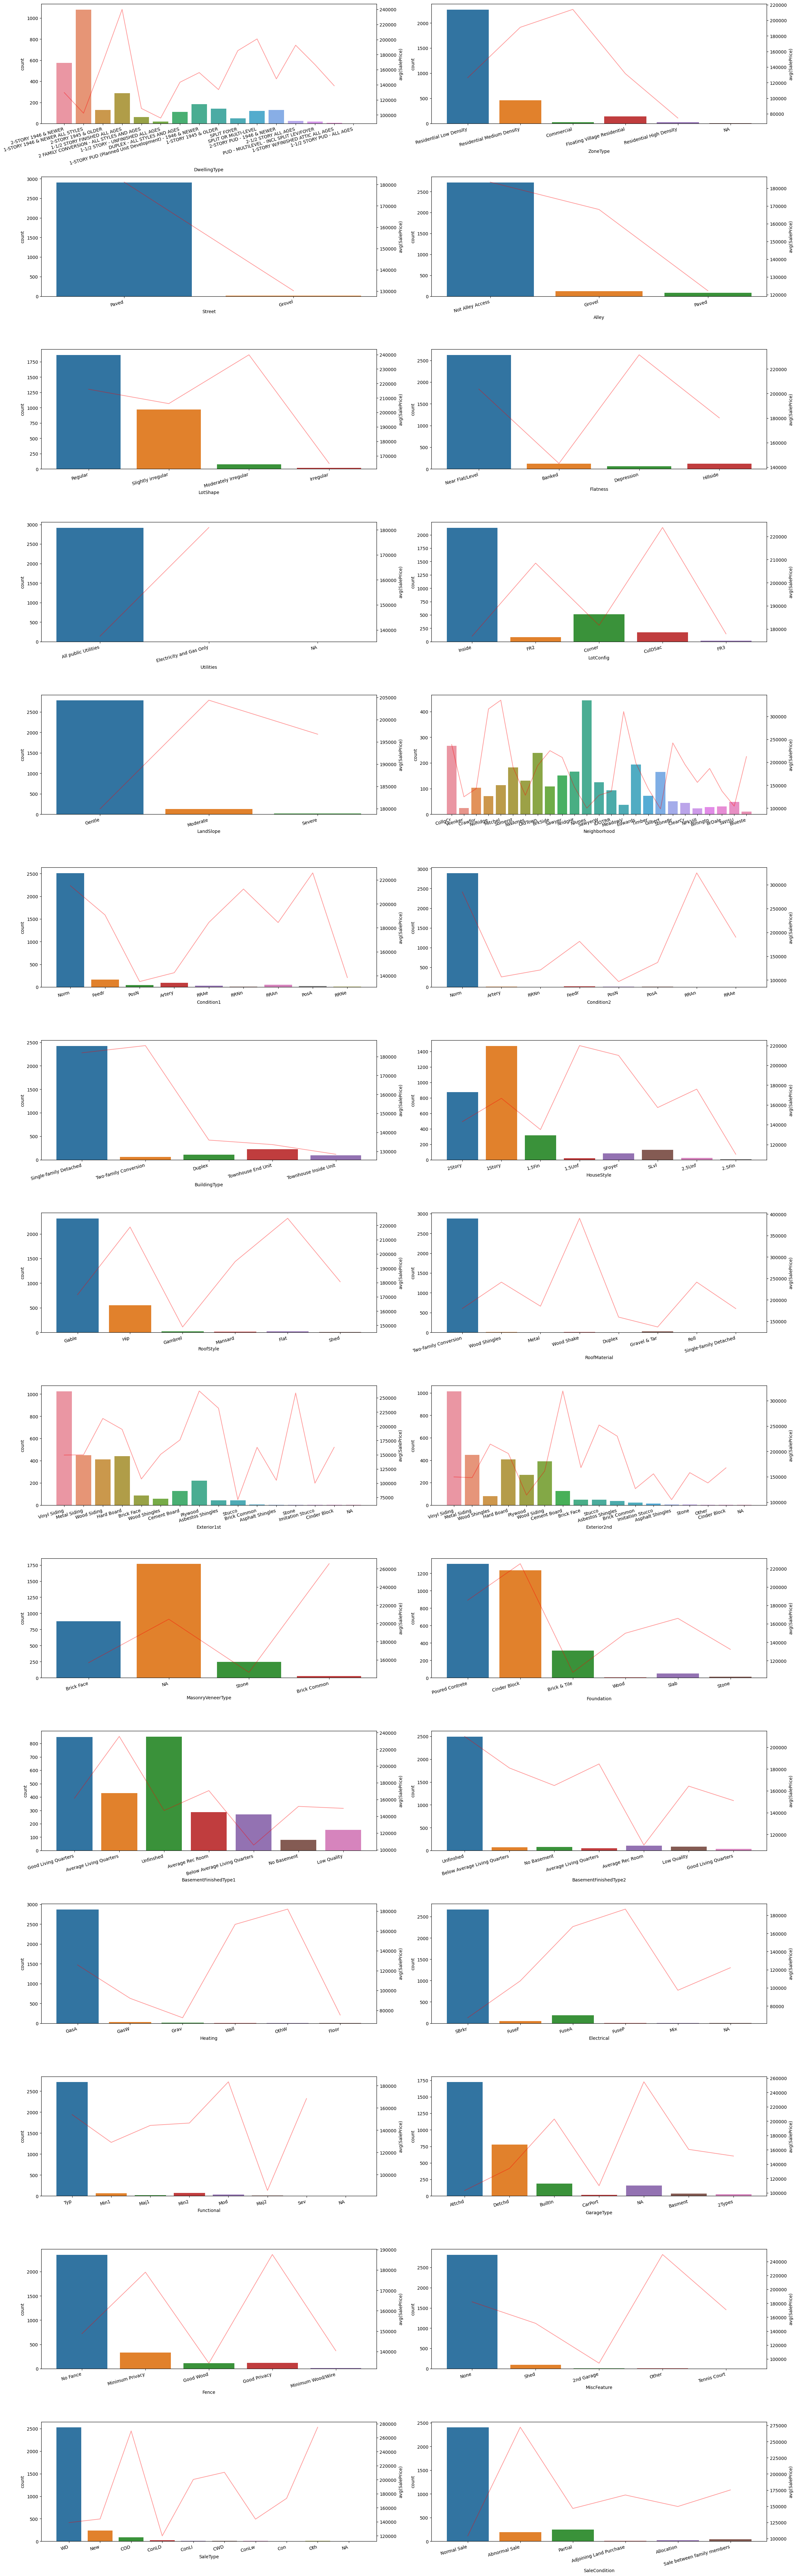

In [12]:
fig, axs = plt.subplots(nrows=15, ncols=2, figsize=(25, 80))
axs = axs.reshape(-1)
for i, col in enumerate(string_cols):
    sns.countplot(data=df.toPandas(), x=col, ax=axs[i])
    axs2 = axs[i].twinx()
    sns.lineplot(data=df.select(col, 'SalePrice').groupby(col).mean().toPandas(), x=col, y='avg(SalePrice)', color='r', alpha=0.4, ax=axs2)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=15, ha="right")
plt.tight_layout()

In [38]:
threshold = 0.5
highly_corr_cols = (matrix[numeric_cols.index('SalePrice'), :] > threshold) | (matrix[numeric_cols.index('SalePrice'), :] < -1 * threshold)
numeric_cols_arr = np.array(numeric_cols)
numeric_cols_arr = numeric_cols_arr[highly_corr_cols]
numeric_cols_arr = numeric_cols_arr.astype(str)
numeric_cols_arr = numeric_cols_arr.tolist()
len(numeric_cols_arr)

30

In [40]:
assembler = VectorAssembler(inputCols=list(numeric_cols_arr), outputCol="features")
df_vector = assembler.transform(df[list(numeric_cols_arr)].dropna())

matrix = Correlation.corr(df_vector, "features", method='spearman')
matrix = matrix.collect()[0][0].toArray()

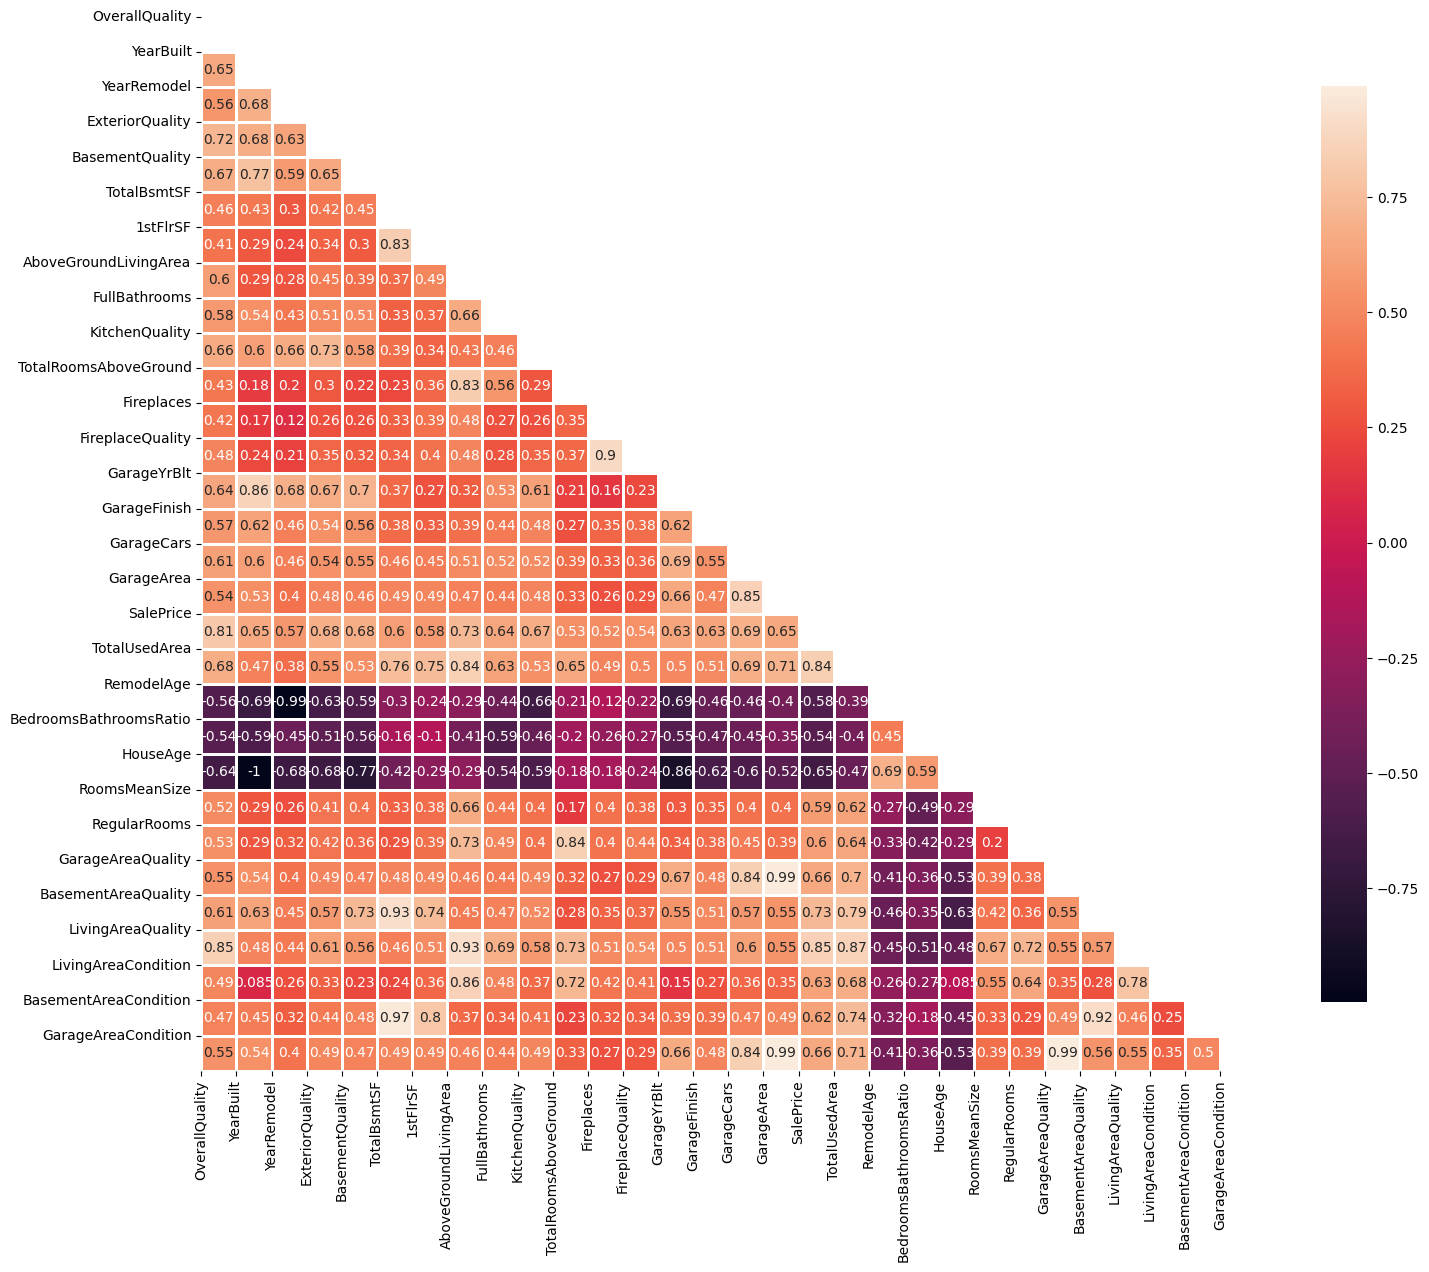

In [43]:
plt.figure(figsize=(17, 17))
triu_mask = np.triu(matrix)
sns.heatmap(matrix, square=True, linewidths=2, mask=triu_mask, annot=True, cbar_kws={"shrink": 0.7})#
plt.xticks(ticks=range(len(numeric_cols_arr)), labels=numeric_cols_arr, rotation=90)
plt.yticks(ticks=range(len(numeric_cols_arr)), labels=numeric_cols_arr, rotation=0)
plt.show();

## Removing numeric uncorrelationed features (Ineffective)

In [15]:
df = df[numeric_cols_arr + string_cols]
df.toPandas()

LotFrontage  LotArea  OverallQuality  OverallConditions  YearBuilt   
0              65     8450               7                  5       2003  \
1              80     9600               6                  8       1976   
2              68    11250               7                  5       2001   
3              60     9550               7                  5       1915   
4              84    14260               8                  5       2000   
...           ...      ...             ...                ...        ...   
2914           21     1936               4                  7       1970   
2915           21     1894               4                  5       1970   
2916          160    20000               5                  7       1960   
2917           62    10441               5                  5       1992   
2918           74     9627               7                  5       1993   

      YearRemodel  MasonryVeneerArea  ExteriorQuality  BasementQuality   
0            2003                196                3                4  \
1            1976                  0                2                4   
2            2002                162                3                4   
3            1970                  0                2                3   
4            2000                350                3                4   
...           ...                ...              ...              ...   
2914         1970                  0                2                3   
2915         1970                  0                2                3   
2916         1996                  0                2                3   
2917         1992                  0                2                4   
2918         1994                 94                2                4   

      BasementCondition  ...    BasementFinishedType1  BasementFinishedType2   
0                     3  ...     Good Living Quarters              Unfinshed  \
1                     3  ...  Average Living Quarters              Unfinshed   
2                     3  ...     Good Living Quarters              Unfinshed   
3                     4  ...  Average Living Quarters              Unfinshed   
4                     3  ...     Good Living Quarters              Unfinshed   
...                 ...  ...                      ...                    ...   
2914                  3  ...                Unfinshed              Unfinshed   
2915                  3  ...         Average Rec Room              Unfinshed   
2916                  3  ...  Average Living Quarters              Unfinshed   
2917                  3  ...     Good Living Quarters              Unfinshed   
2918                  3  ...              Low Quality              Unfinshed   

      Heating  Electrical  Functional  GarageType            Fence   
0        GasA       SBrkr         Typ      Attchd         No Fance  \
1        GasA       SBrkr         Typ      Attchd         No Fance   
2        GasA       SBrkr         Typ      Attchd         No Fance   
3        GasA       SBrkr         Typ      Detchd         No Fance   
4        GasA       SBrkr         Typ      Attchd         No Fance   
...       ...         ...         ...         ...              ...   
2914     GasA       SBrkr         Typ          NA         No Fance   
2915     GasA       SBrkr         Typ     CarPort         No Fance   
2916     GasA       SBrkr         Typ      Detchd         No Fance   
2917     GasA       SBrkr         Typ          NA  Minimum Privacy   
2918     GasA       SBrkr         Typ      Attchd         No Fance   

      MiscFeature  SaleType  SaleCondition  
0            None        WD    Normal Sale  
1            None        WD    Normal Sale  
2            None        WD    Normal Sale  
3            None        WD  Abnormal Sale  
4            None        WD    Normal Sale  
...           ...       ...            ...  
2914         None        WD    Normal Sale  
2915         None        WD  Abnormal Sale

## Removing outliers (Ineffective)

In [17]:
limit_values_cols = {
    'LotFrontage': 250,
    'LotArea': 100000,
    'MiscVal': 5000
}

In [18]:
df_train = df[~df["SalePrice"].isNull()]
df_test = df[df["SalePrice"].isNull()]

In [35]:
outliers_df = spark.createDataFrame(data=[], schema=df.schema)
inliers_df = df
for col, value in limit_values_cols.items():
    outliers = df_train[df_train[col] >= value]
    inliers_df = df_train[df_train[col] < value]
    
    #median = df.agg(func.percentile_approx(col, 0.5).alias("median")).collect()[0][0]
    #df = df.withColumn(col, func.when(df[col] < value, df[col]).otherwise(median))
    outliers_df = outliers_df.union(outliers)

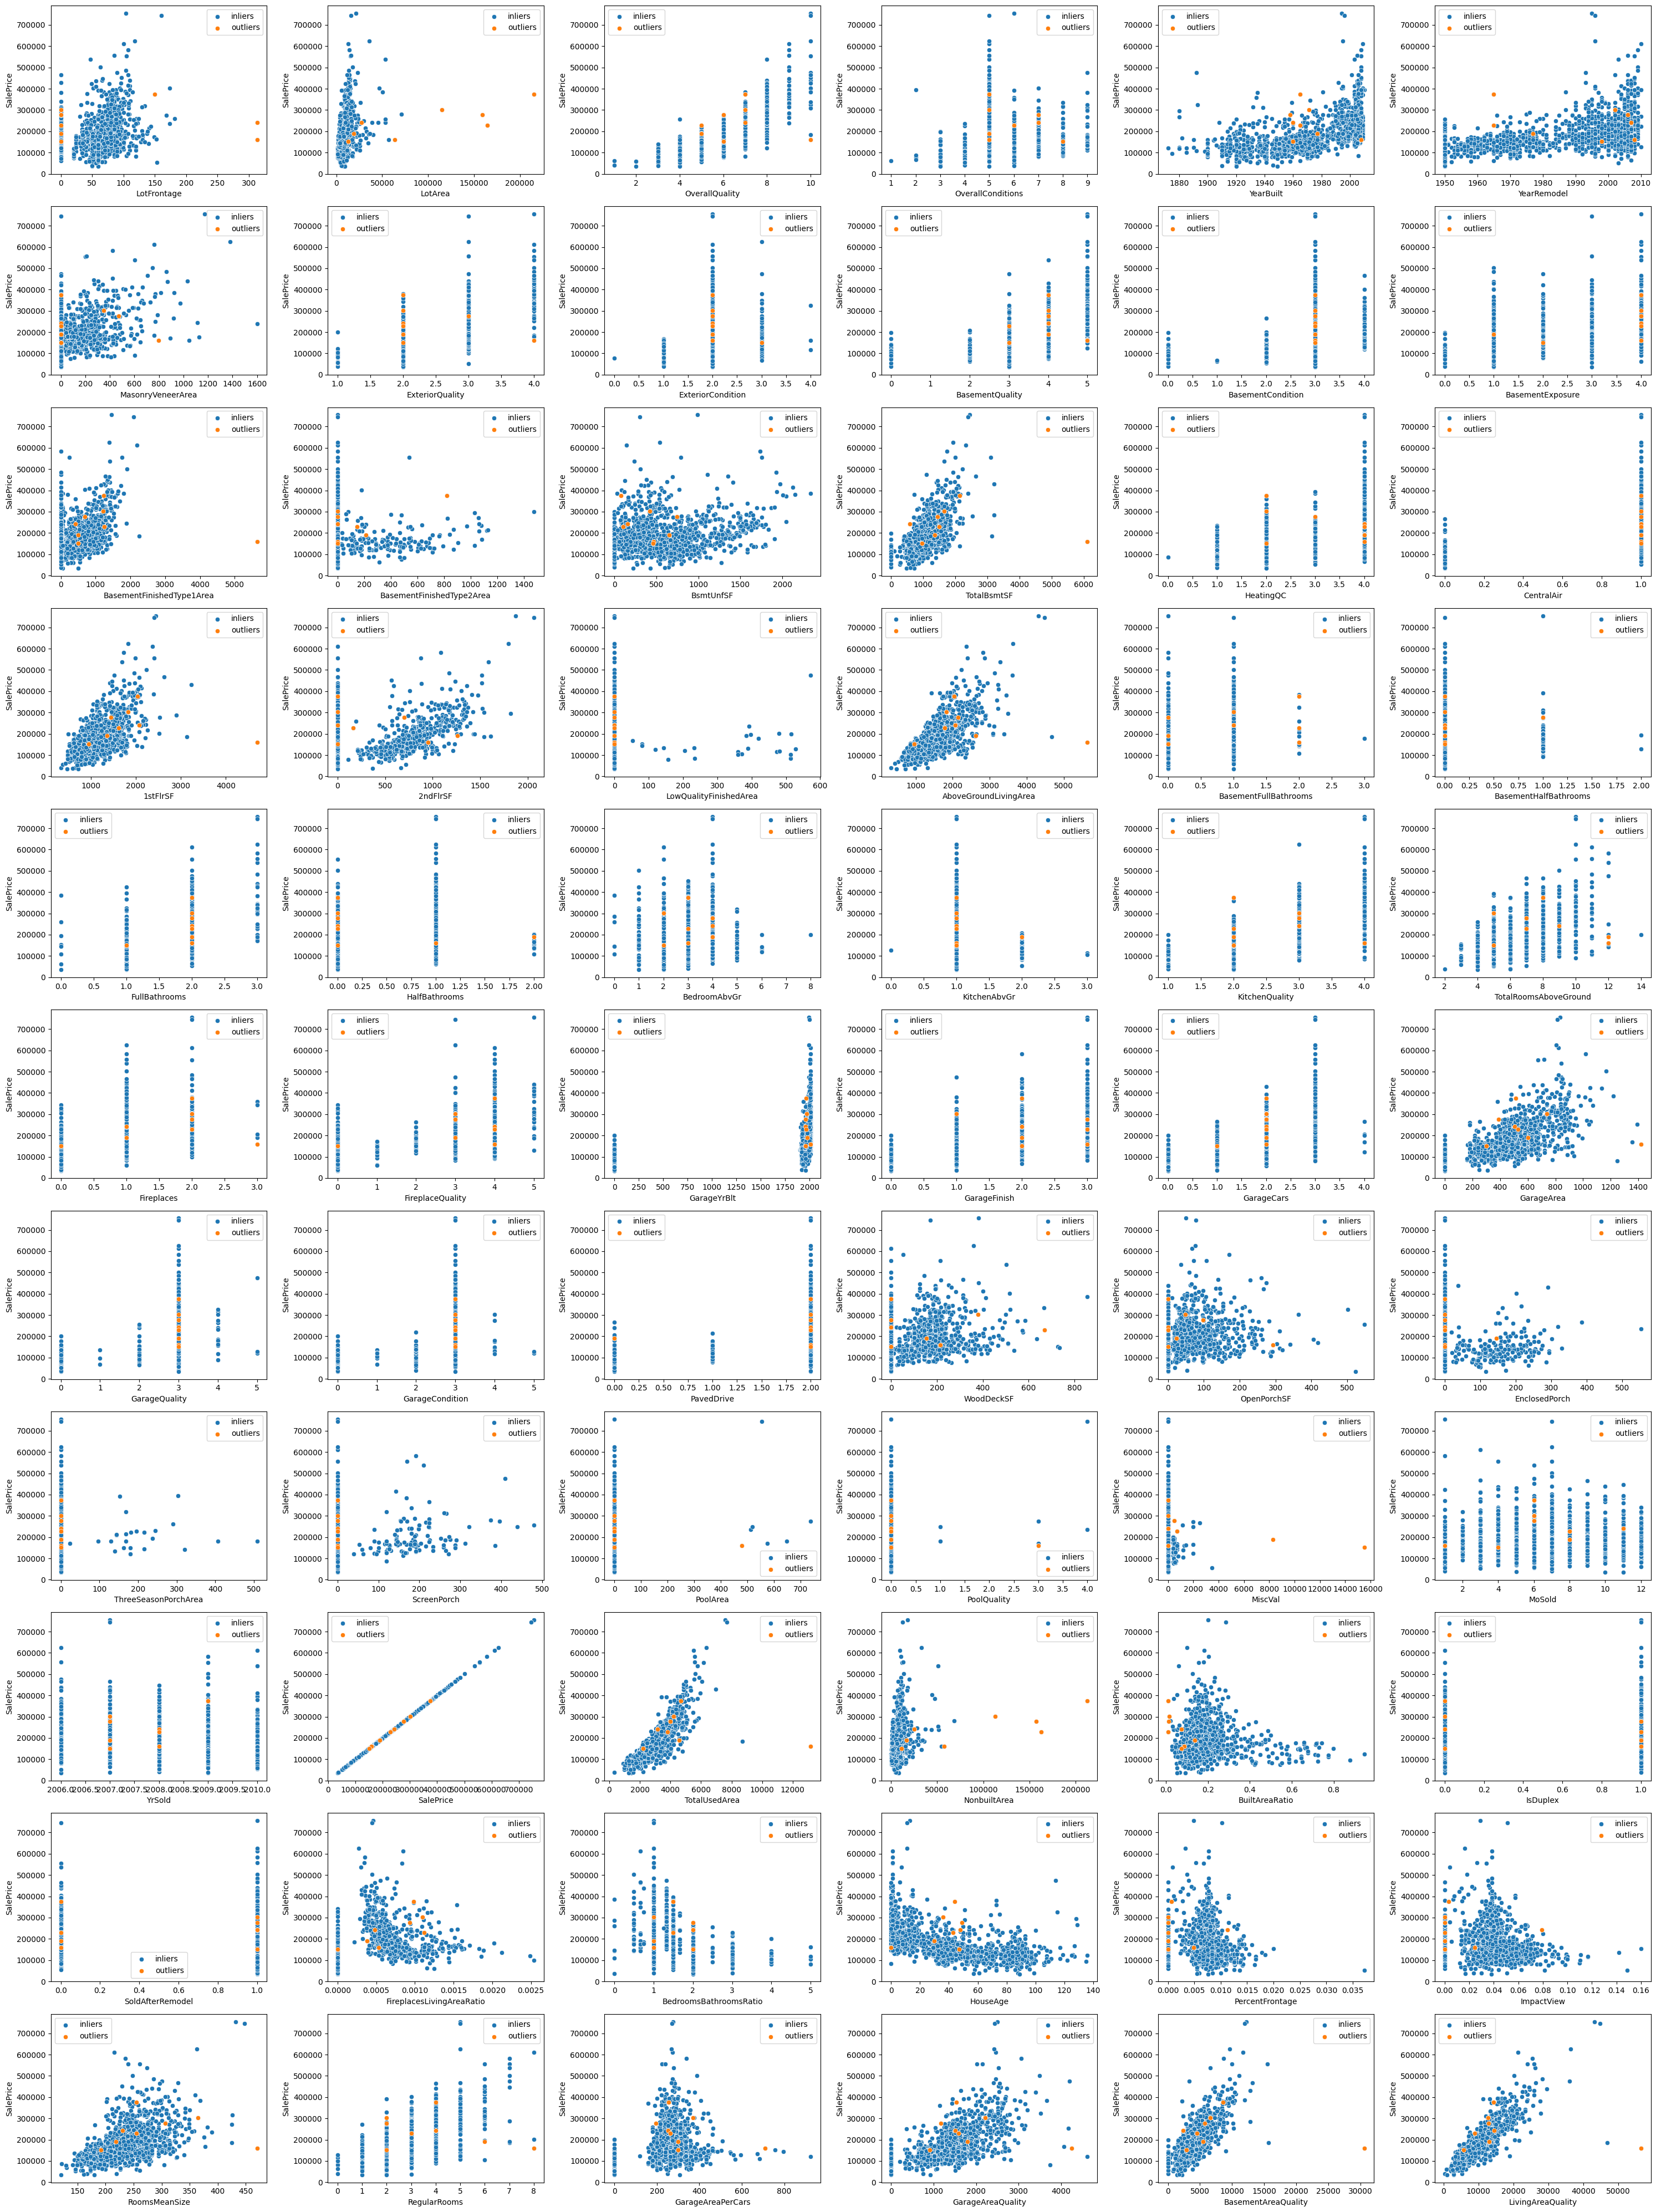

In [36]:
fig, axes = plt.subplots(nrows=11, ncols=6, figsize=(30, 40))
axes = np.ravel(axes)
for i, col in enumerate(numeric_cols):
    sns.scatterplot(data=inliers_df.toPandas(), x=col, y='SalePrice', ax=axes[i], label='inliers')
    sns.scatterplot(data=outliers_df.toPandas(), x=col, y='SalePrice', ax=axes[i], label='outliers')
    #sns.scatterplot(data=df.toPandas(), x=col, y='SalePrice', ax=axes[i])
plt.tight_layout()

In [37]:
df = df_train.union(df_test)

In [16]:
df.write.csv(path='data/house_data_v2', header=True, mode='overwrite')